# Scaling Python with Azure ML and Dask

![Describe gif](media/describe.gif)

## Environment setup

This notebook assumes you are using an Azure ML Compute Instance with the default kernel `azureml_py36`. This contains many unneccesary packages. If you want to avoid a long image build time, you may want to create a new conda environment with the minimal packages needed for your scenario. 

It is important that the local environment matches the remote environment to avoid mismatch issues when submitting commands to the remote cluster. To help with this, we will use Azure ML Environments. 

In [ ]:
pip install --upgrade dask[complete] adlfs lz4 distributed fastparquet pyarrow azureml-sdk[notebooks] dask-ml[complete] tpot 

Uninstall some bugs.

In [ ]:
pip uninstall azureml-samples azureml-mlflow -y

## Important! 

Restart your kernel.

In [1]:
# this is for a strange bug with compute instances 
import os

os.system('sudo cp /etc/nginx/nginx.conf setup/temp.conf') # stupid

nginx = ''

with open('setup/temp.conf') as f:
    for line in f.readlines():
        if 'websocket/|/ws/' in line:
            nginx += line.replace('websocket/|/ws/', 'websocket/|/ws')
        else:
            nginx += line
       
with open('setup/temp2.conf', 'w') as f:
    f.write(nginx)
    
os.system('sudo mv setup/temp2.conf /etc/nginx/nginx.conf')
os.system('sudo service nginx restart')
os.system('rm setup/temp.conf');

## Imports

Import all packages used in this notebook.

In [2]:
import os
import sys
import dask
import glob
import time
import socket
import matplotlib

import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

from datetime import datetime
from dask.distributed import Client
from IPython.core.display import HTML

from azureml.widgets import RunDetails
from azureml.train.estimator import Estimator
from azureml.core.runconfig import MpiConfiguration
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.conda_dependencies import CondaDependencies 
from azureml.core import Workspace, Experiment, Dataset, Environment

%matplotlib inline 

Failure while loading azureml_run_type_providers. Failed to load entrypoint hyperdrive = azureml.train.hyperdrive:HyperDriveRun._from_run_dto with exception cannot import name '_DistributedTraining'.


## Azure ML setup

Get the workspace.

In [3]:
ws = Workspace.from_config()
ws

Workspace.create(name='ncus-azureml', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copeters-rg')

### Data access setup

This is for a ADLS gen2 account I have provisioned with data. It should be read-able publicly.

You **should not** keep storage account keys in plain text format, and you definitely should not upload them to github in a public repo. 

Use the keyvault with the workspace through the Python SDK or Azure Portal to set the account name and key for your storage account, and use the keyvault to retrieve the secrets and pass them through. 

In [4]:
keyvault = ws.get_default_keyvault()
keyvault.set_secret('daskdataaccount', 'data4dask')
keyvault.set_secret('daskdatakey', 'mupxHTCWrYQC252cFAWCAm7lSlMPTCt5J3j7FCXIlXW/k3OIdLrWssVnMGKVX6N96XoIlw9O8PkQya3cNB9xKw==')

In [5]:
STORAGE_OPTIONS = {
    'account_name': keyvault.get_secret('daskdataaccount'), 
    'account_key' : keyvault.get_secret('daskdatakey')
}

abfs_path = 'abfs://datasets/noaa/isd'

### Create environment 

Create the environment to be used on the remote cluster. 

In [6]:
env_name = 'dask-ml-env'

if env_name not in ws.environments:
    env = Environment.from_existing_conda_environment(env_name, 'azureml_py36')
    env.python.conda_dependencies.add_pip_package('mpi4py') # needed for remote cluster
    env = env.register(ws)
else:
    env = ws.environments[env_name]
    
env.name, env.version

('dask-ml-env', '1')

### Create VM pool

Create Azure ML VM pool for creating remote dask cluster(s).

In [7]:
pool_name = 'raspberrypis'

if pool_name not in ws.compute_targets:
    # create config for Azure ML cluster
    # change properties as needed
    config = AmlCompute.provisioning_configuration(
             vm_size                       = 'STANDARD_D13_V2',   # 8 vCPUS 56 GB RAM 112 GB disk 
             max_nodes                     = 100,
             vnet_resourcegroup_name       = ws.resource_group,   # replace if needed
             vnet_name                     = 'dialup-network',    # replace if needed
             subnet_name                   = 'default',           # replace if needed
             idle_seconds_before_scaledown = 300
    )
    ct = ComputeTarget.create(ws, pool_name, config)
    ct.wait_for_completion(show_output=True)    
else:
    ct = ws.compute_targets[pool_name]
    
ct

AmlCompute(workspace=Workspace.create(name='ncus-azureml', subscription_id='6560575d-fa06-4e7d-95fb-f962e74efd7a', resource_group='copeters-rg'), name=raspberrypis, id=/subscriptions/6560575d-fa06-4e7d-95fb-f962e74efd7a/resourceGroups/copeters-rg/providers/Microsoft.MachineLearningServices/workspaces/ncus-azureml/computes/raspberrypis, type=AmlCompute, provisioning_state=Succeeded, location=northcentralus, tags=None)

## Startup cluster

Start the run now. The first time, this will take 

In [8]:
exp_name   = 'dask-interactive'

est = Estimator('setup', 
                compute_target          = ct, 
                entry_script            = 'start.py',          # sets up Dask cluster
                environment_definition  = env,                 # use same env as local
                node_count              = 20,                  # 20 nodes -> 160 vCPUs, 1 TB RAM
                distributed_training    = MpiConfiguration()
               )

#run = next(ws.experiments[exp_name].get_runs()) # use this to get existing run (if kernel restarted, etc)
run = Experiment(ws, exp_name).submit(est)
run

WARNING - This compute target type doesn't support non-Docker runs; overriding run configuration enable Docker.


Experiment,Id,Type,Status,Details Page,Docs Page
dask-interactive,dask-interactive_1578791783_b752dd82,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


## Pandas

In [9]:
abfs_path

'abfs://datasets/noaa/isd'

In [10]:
# adjust months as needed
m1 = 1
m2 = 3
# get list of files to read
files = [f'{abfs_path}/year=2019/month={m}/*.parquet' for m in range(m1, m2+1)]
# use dask to read from abfs, convert to pandas 
%time df = dd.read_parquet(files, engine='pyarrow', storage_options=STORAGE_OPTIONS).compute()

CPU times: user 21.9 s, sys: 9.52 s, total: 31.4 s
Wall time: 40.2 s


In [11]:
type(df) # confirm it's Pandas not Dask 

pandas.core.frame.DataFrame

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32856415 entries, 0 to 11120197
Data columns (total 22 columns):
usaf                       object
wban                       object
datetime                   datetime64[ns]
latitude                   float64
longitude                  float64
elevation                  float64
windAngle                  float64
windSpeed                  float64
temperature                float64
seaLvlPressure             float64
cloudCoverage              object
presentWeatherIndicator    float64
pastWeatherIndicator       float64
precipTime                 float64
precipDepth                float64
snowDepth                  float64
stationName                object
countryOrRegion            object
p_k                        object
year                       int32
day                        int32
version                    float64
dtypes: datetime64[ns](1), float64(13), int32(2), object(6)
memory usage: 5.4+ GB


In [13]:
%time len(df)

CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 15 µs


32856415

In [14]:
%time df.describe()

CPU times: user 18.6 s, sys: 5.86 s, total: 24.4 s
Wall time: 24.4 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,3.285642e+07,3.285642e+07,3.285642e+07,2.737103e+07,2.830008e+07,3.214719e+07,1.312654e+07,4.127135e+06,1.225663e+06,8.103505e+06,8.103505e+06,365951.000000,32856415.0,3.285642e+07,32856415.0
mean,3.636384e+01,-3.717028e+01,3.906849e+02,1.726250e+02,3.676873e+00,4.585060e+00,1.016144e+03,4.014241e+01,4.181772e+00,1.519034e+01,2.275987e+03,26.477517,2019.0,1.550101e+01,1.0
std,2.318415e+01,7.814036e+01,7.242126e+02,1.157004e+02,3.072554e+00,1.337377e+01,1.086895e+01,3.052282e+01,2.961840e+00,2.991428e+01,4.182790e+03,29.773343,0.0,8.723274e+00,0.0
min,-9.000000e+01,-1.799830e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-9.130000e+01,8.988000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2019.0,1.000000e+00,1.0
25%,3.278200e+01,-9.555600e+01,3.600000e+01,7.000000e+01,1.500000e+00,-3.000000e+00,1.010300e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,1.000000,2019.0,8.000000e+00,1.0
50%,4.121700e+01,-7.543300e+01,1.780000e+02,1.800000e+02,3.100000e+00,4.000000e+00,1.016400e+03,5.100000e+01,4.000000e+00,1.000000e+00,0.000000e+00,20.000000,2019.0,1.500000e+01,1.0
75%,4.845000e+01,1.568600e+01,4.300000e+02,2.700000e+02,5.100000e+00,1.300000e+01,1.023100e+03,7.100000e+01,7.000000e+00,1.200000e+01,6.000000e+01,43.000000,2019.0,2.300000e+01,1.0
max,8.365600e+01,1.797500e+02,9.999000e+03,3.600000e+02,8.800000e+01,6.150000e+01,1.089500e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,697.000000,2019.0,3.100000e+01,1.0


In [15]:
%time bites = df.memory_usage(index=True, deep=True).sum()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 15 s, sys: 41.3 ms, total: 15.1 s
Wall time: 15 s
Dataframe is: 16.0GB


In [16]:
%time means = df.groupby(df.datetime.dt.floor('d')).mean()
means.head()

CPU times: user 2.43 s, sys: 969 ms, total: 3.4 s
Wall time: 3.4 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
datetime,,,,,,,,,,,,,,,
2019-01-01,36.281951,-37.040627,392.396704,188.552802,4.044324,4.391837,1017.214198,40.251434,4.295040,15.533651,2300.457644,14.674692,2019,1,1.0
2019-01-02,36.369198,-37.290084,384.415207,175.098038,3.546742,3.250356,1018.311258,41.647164,4.646093,15.166829,2288.816866,16.738155,2019,2,1.0
2019-01-03,36.234547,-37.245756,384.442712,176.419014,3.390573,4.073418,1017.700144,42.984876,4.553081,14.486512,2214.186560,17.179716,2019,3,1.0
2019-01-04,36.291708,-36.901728,381.026500,178.444538,3.298544,4.891948,1016.072151,39.800114,4.571939,14.999360,2268.404353,17.323634,2019,4,1.0
2019-01-05,36.403439,-36.794582,384.924976,180.592511,3.155102,4.689213,1015.744552,38.390121,4.646371,15.530488,2268.322695,19.368870,2019,5,1.0


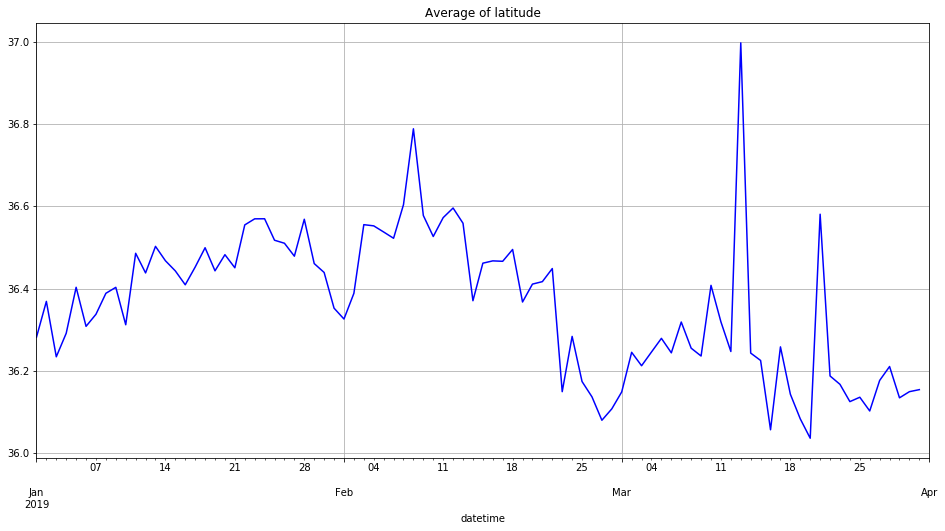

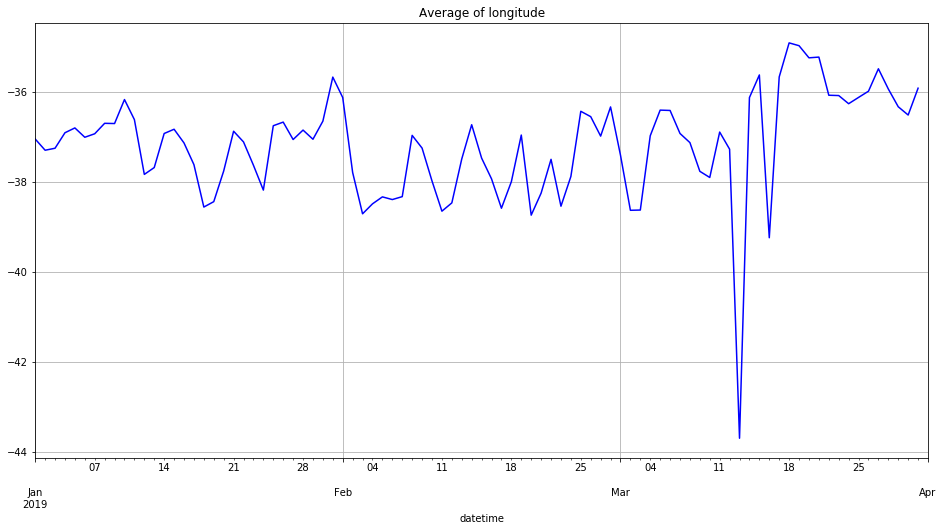

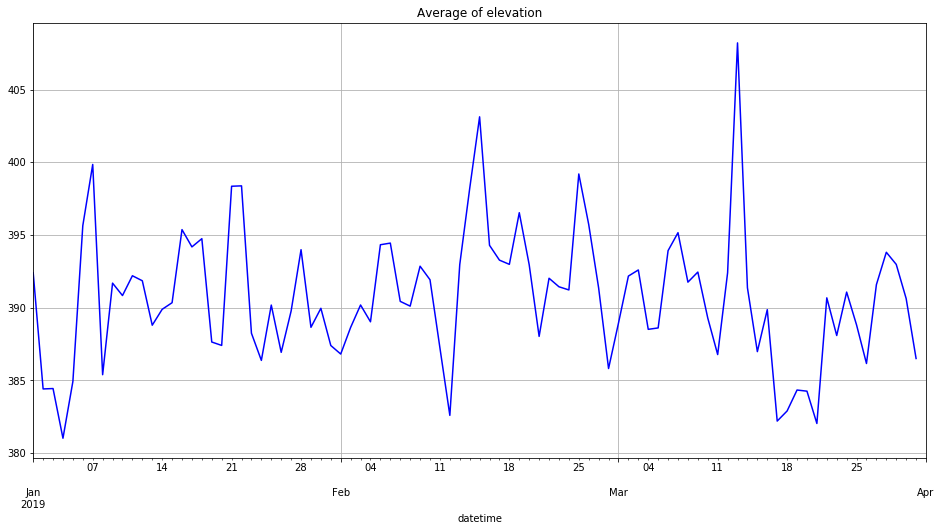

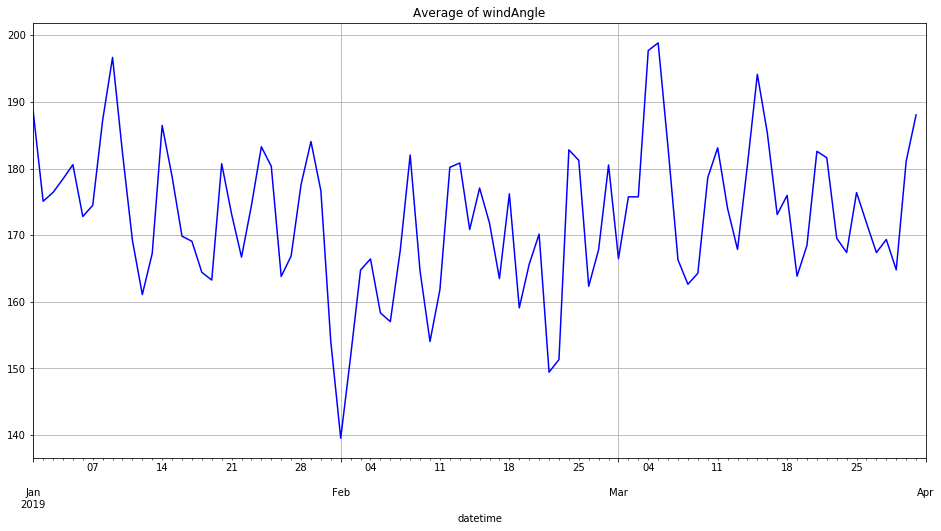

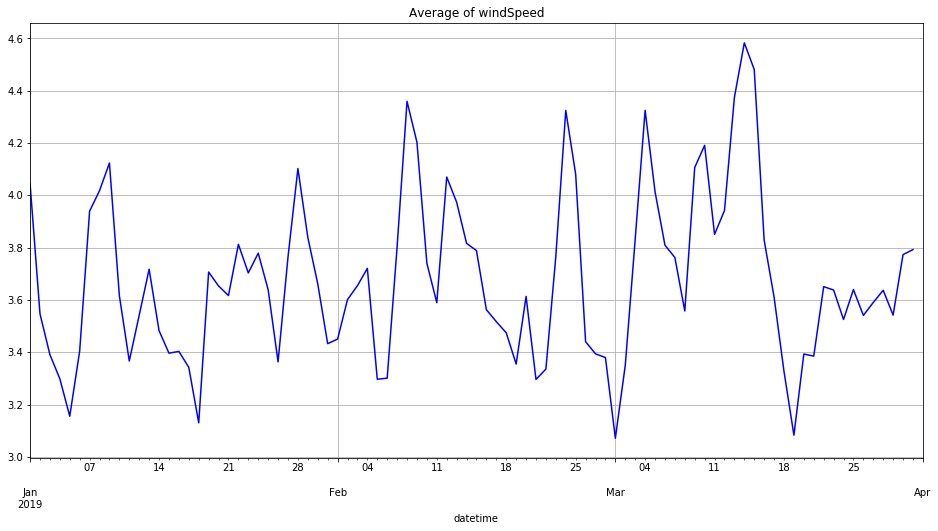

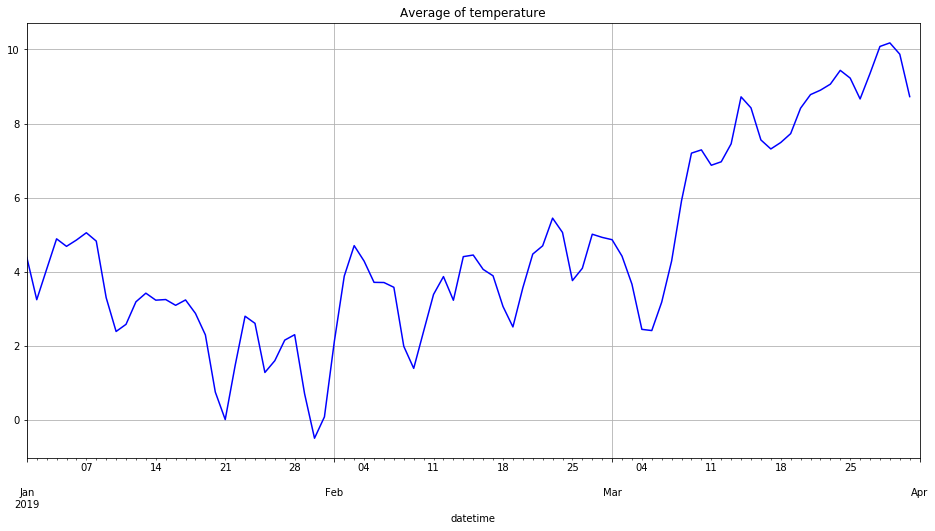

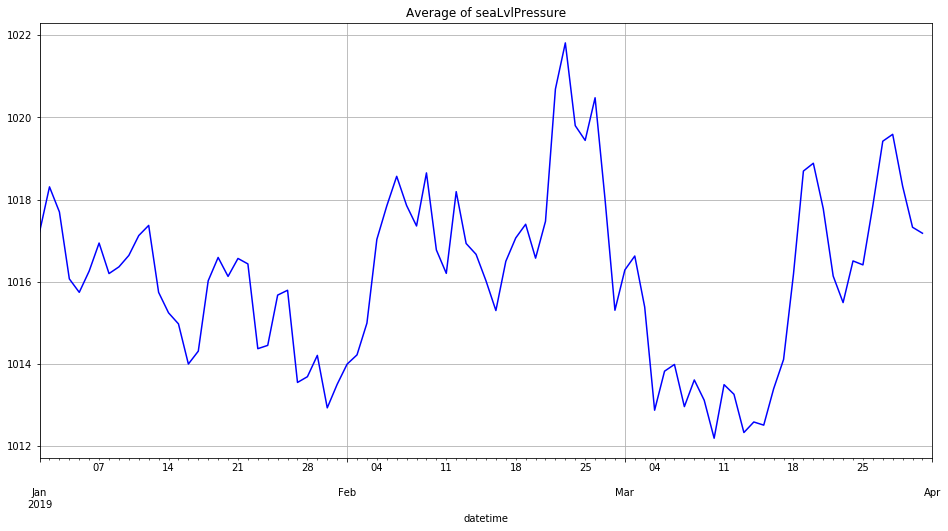

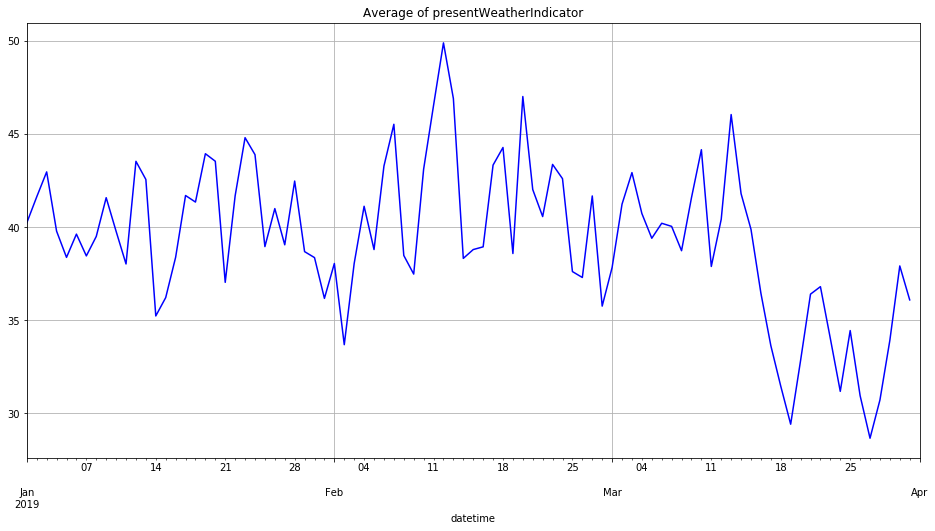

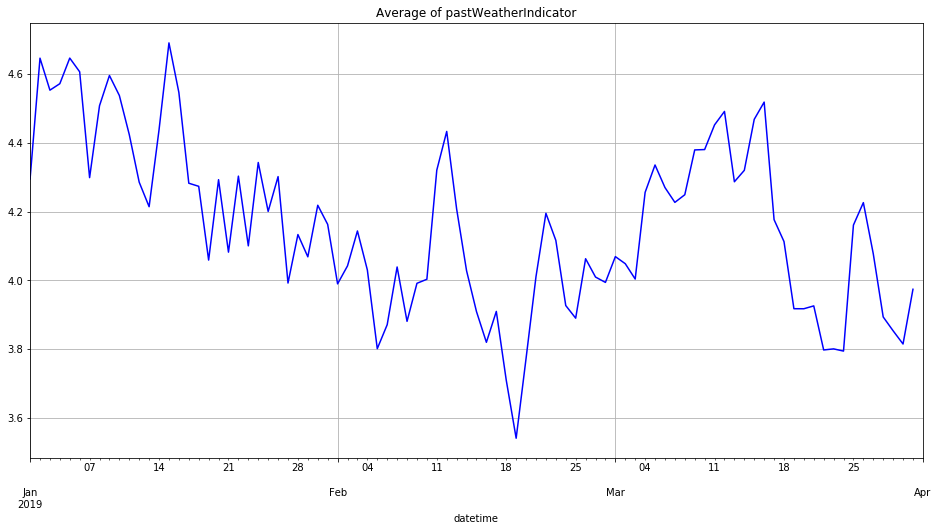

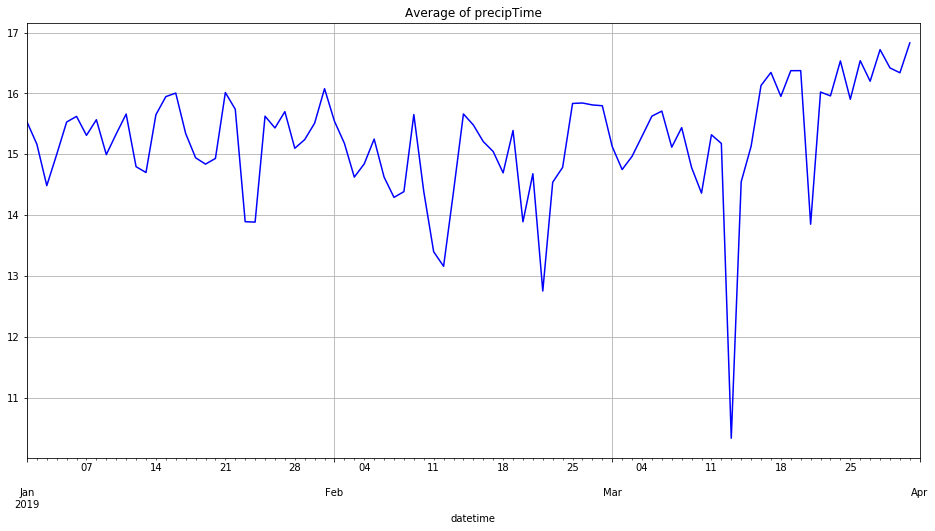

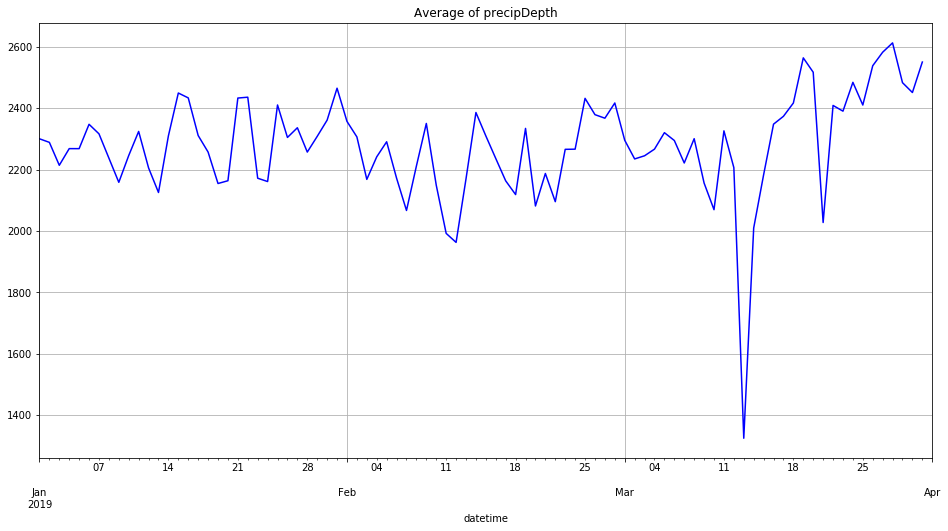

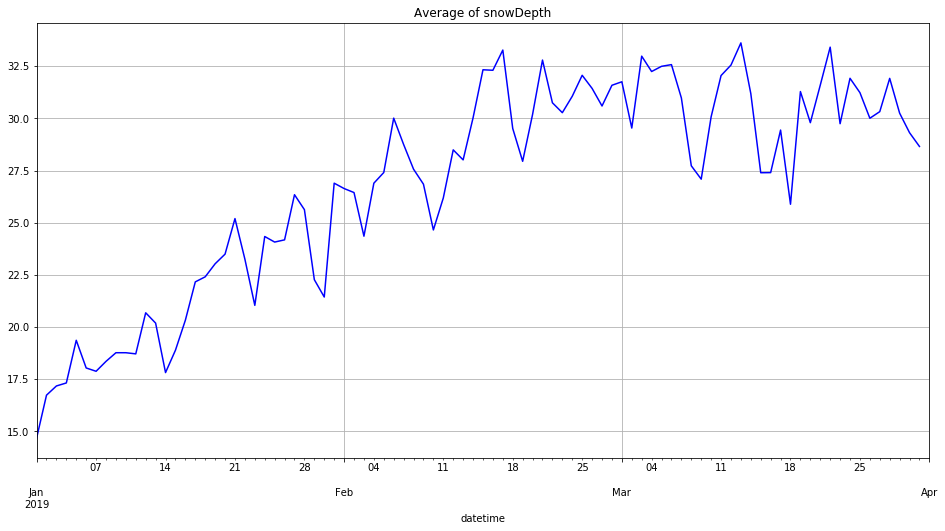

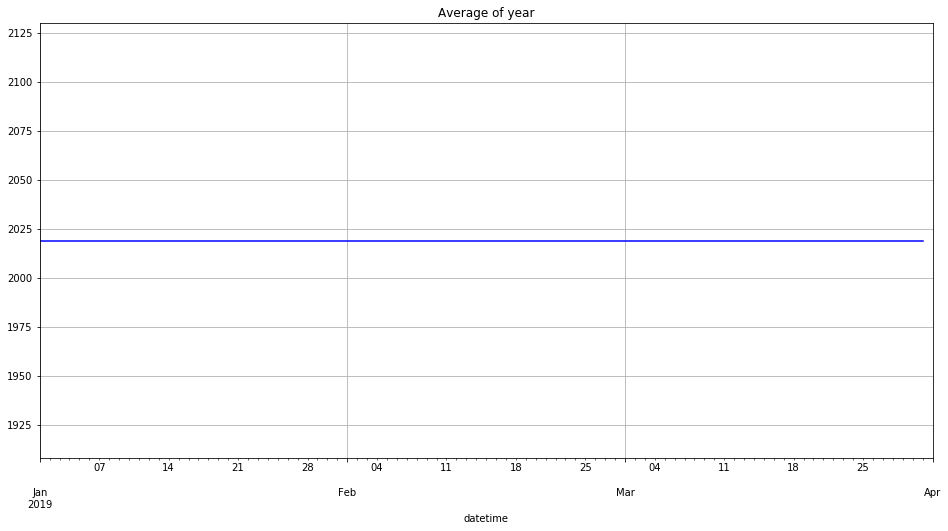

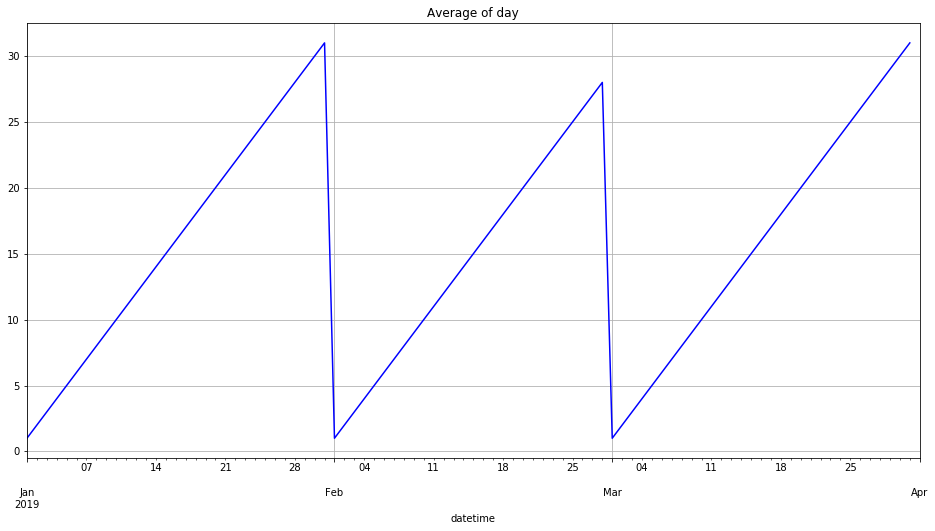

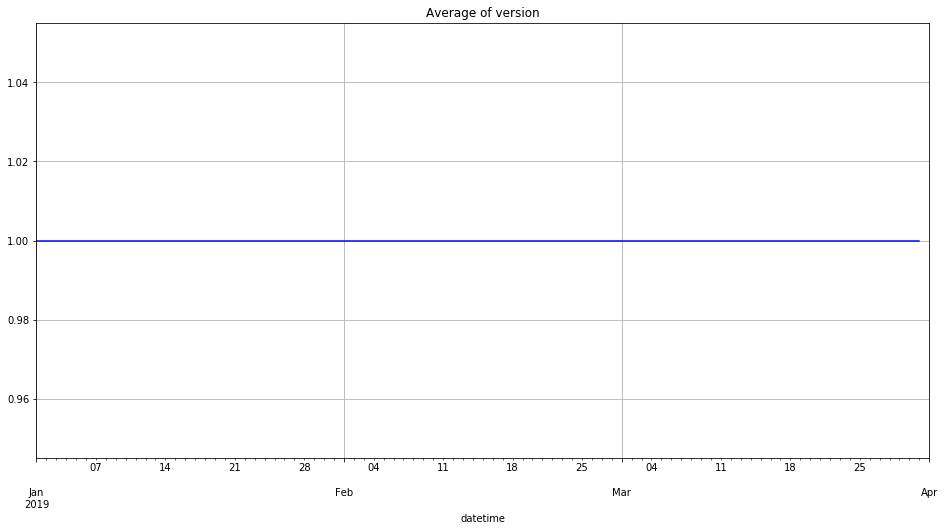

In [17]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2019, m1, 1), datetime(2019, m2+1, 1)])
    plt.grid()

## Scaling with Dask 'locally'

The first step in scaling up with Dask is to simply get a bigger VM. For non-GPU Compute Instances, the max is the `STANDARD_DS15_V2` with 20 cores and 140 GB of RAM. This is suitable for interactive querying and data preparation on about 1 year of the weather data, but not on the full dataset.

In [18]:
dashboard_port = 4444

# start the distributed scheduler 
c = Client(dashboard_address=f':{dashboard_port}')
print(f'\n\n{c}')

# need to get the dashboard link 
dashboard_url = f'https://{socket.gethostname()}-{dashboard_port}.{ws.get_details()["location"]}.instances.azureml.net/status'
HTML(f'<a href="{dashboard_url}">Dashboard link</a>')



<Client: 'tcp://127.0.0.1:35535' processes=5 threads=20, memory=147.86 GB>


### Take some data

Take some data. The below cells may fail on smaller VMs. You can use the dashboard to understand what is going on with this VM being used as a "local" cluster. 

In [19]:
# adjust amount of data as needed
y1 = 2019
y2 = 2019
# build list of files 
files = [f'{abfs_path}/year={year}/month={m}/*.parquet' for year in range(y1, y2+1) for m in range(1, 12+1)]
# read into dask dataframe
df = dd.read_parquet(files, engine='pyarrow', storage_options=STORAGE_OPTIONS)
%time df.head()

CPU times: user 651 ms, sys: 75.3 ms, total: 726 ms
Wall time: 11.2 s


,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,999999,54933,2019-01-01 00:00:00,45.711,-99.130,596.0,0.0,0.0,-21.7,NaN,...,NaN,1.0,0.0,NaN,ABERDEEN 35 WNW,US,999999-54933,2019,1,1.0
1,725910,24216,2019-01-29 00:00:00,40.150,-122.250,108.0,280.0,2.6,15.6,1015.9,...,NaN,NaN,NaN,NaN,RED BLUFF MUNICIPAL ARPT,US,725910-24216,2019,29,1.0
2,999999,54933,2019-01-01 00:05:00,45.711,-99.130,596.0,NaN,NaN,-21.8,NaN,...,NaN,NaN,NaN,NaN,ABERDEEN 35 WNW,US,999999-54933,2019,1,1.0
3,725910,24216,2019-01-29 00:54:00,40.152,-122.253,108.0,130.0,3.6,16.1,1016.1,...,NaN,1.0,0.0,NaN,RED BLUFF MUNICIPAL ARPT,US,725910-24216,2019,29,1.0
4,999999,54933,2019-01-01 00:10:00,45.711,-99.130,596.0,NaN,NaN,-21.8,NaN,...,NaN,NaN,NaN,NaN,ABERDEEN 35 WNW,US,999999-54933,2019,1,1.0


In [20]:
%time len(df)

CPU times: user 415 ms, sys: 48.2 ms, total: 463 ms
Wall time: 6.36 s


126437348

In [21]:
%time df.describe().compute()

CPU times: user 6.64 s, sys: 988 ms, total: 7.63 s
Wall time: 1min 3s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,1.264373e+08,1.264373e+08,1.264373e+08,1.081204e+08,1.119876e+08,1.236500e+08,5.238586e+07,1.349315e+07,4.395290e+06,3.145815e+07,3.145815e+07,1.069779e+06,126437348.0,1.264373e+08,126437348.0
mean,3.604432e+01,-3.447224e+01,3.813459e+02,1.661079e+02,3.402335e+00,1.239033e+01,1.014633e+03,3.621682e+01,4.208635e+00,1.574683e+01,2.404793e+03,1.370524e+01,2019.0,1.565826e+01,1.0
std,2.367515e+01,7.835447e+01,6.997173e+02,1.140893e+02,2.822951e+00,1.260194e+01,9.167061e+00,3.022919e+01,3.024070e+00,3.035131e+01,4.264187e+03,2.474551e+01,0.0,8.822810e+00,0.0
min,-9.000000e+01,-1.799830e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-9.130000e+01,8.614000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2019.0,1.000000e+00,1.0
25%,3.283500e+01,-9.167300e+01,3.700000e+01,7.000000e+01,1.500000e+00,6.900000e+00,1.011000e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2019.0,8.000000e+00,1.0
50%,4.163300e+01,-4.923200e+01,1.820000e+02,1.900000e+02,3.100000e+00,1.590000e+01,1.017300e+03,6.000000e+01,5.000000e+00,1.000000e+00,0.000000e+00,3.000000e+00,2019.0,1.600000e+01,1.0
75%,4.913300e+01,2.095000e+01,4.360000e+02,2.800000e+02,5.100000e+00,2.700000e+01,1.024600e+03,7.100000e+01,8.000000e+00,1.200000e+01,9.999000e+03,5.100000e+01,2019.0,2.400000e+01,1.0
max,8.365600e+01,1.797500e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.150000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,7.000000e+02,2019.0,3.100000e+01,1.0


In [22]:
%time bites = df.memory_usage(index=True, deep=True).sum().compute()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 1.83 s, sys: 297 ms, total: 2.12 s
Wall time: 34.6 s
Dataframe is: 60.7GB


In [23]:
%time means = df.groupby(df.datetime.dt.floor('d')).mean().compute() 
means.head()

CPU times: user 2.05 s, sys: 288 ms, total: 2.33 s
Wall time: 33 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
datetime,,,,,,,,,,,,,,,
2019-01-01,36.281951,-37.040627,392.396704,188.552802,4.044324,4.391837,1017.214198,40.251434,4.295040,15.533651,2300.457644,14.674692,2019.0,1.0,1.0
2019-01-02,36.369198,-37.290084,384.415207,175.098038,3.546742,3.250356,1018.311258,41.647164,4.646093,15.166829,2288.816866,16.738155,2019.0,2.0,1.0
2019-01-03,36.234547,-37.245756,384.442712,176.419014,3.390573,4.073418,1017.700144,42.984876,4.553081,14.486512,2214.186560,17.179716,2019.0,3.0,1.0
2019-01-04,36.291708,-36.901728,381.026500,178.444538,3.298544,4.891948,1016.072151,39.800114,4.571939,14.999360,2268.404353,17.323634,2019.0,4.0,1.0
2019-01-05,36.403439,-36.794582,384.924976,180.592511,3.155102,4.689213,1015.744552,38.390121,4.646371,15.530488,2268.322695,19.368870,2019.0,5.0,1.0


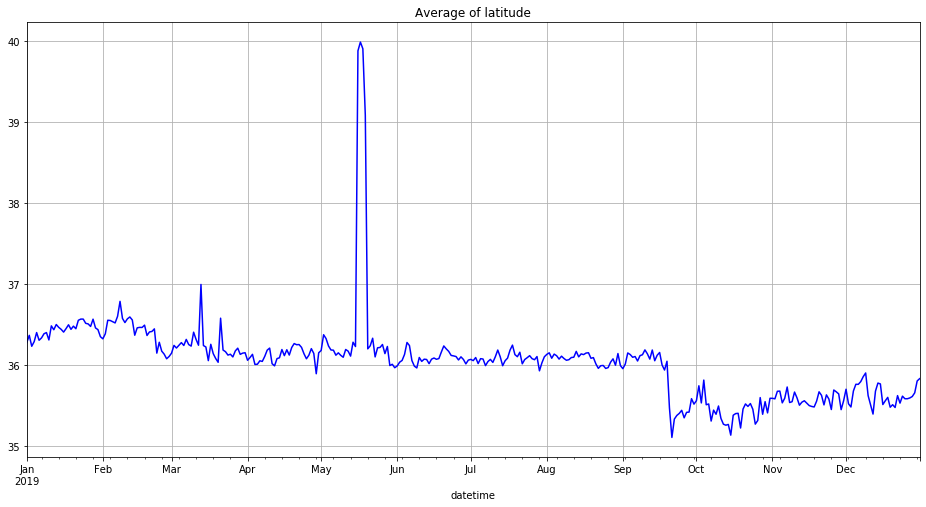

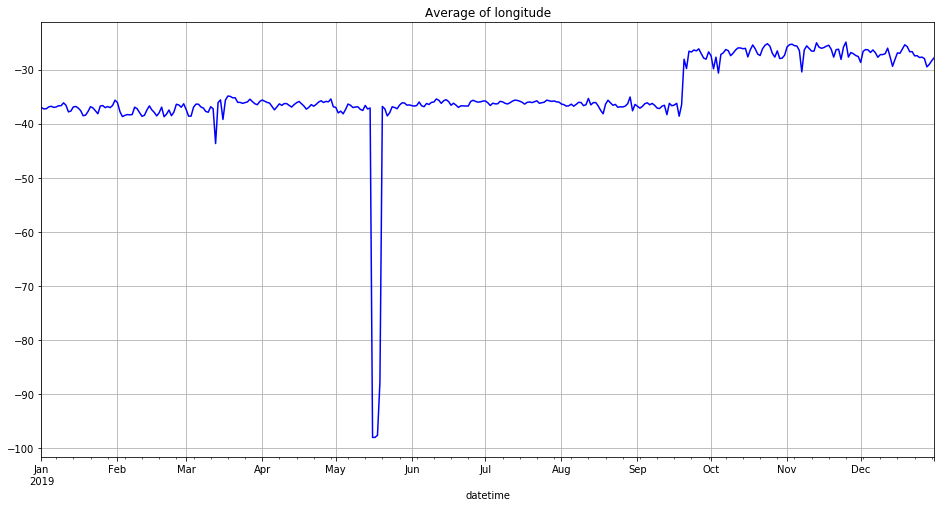

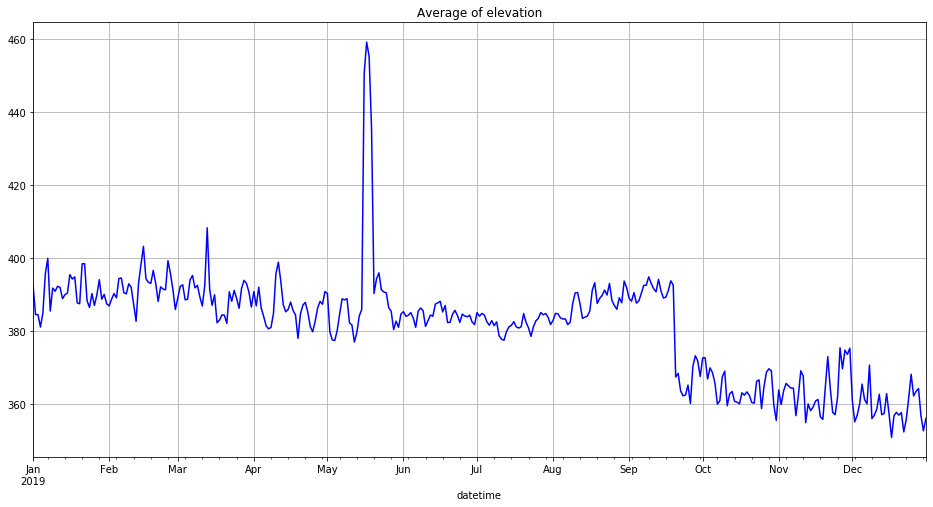

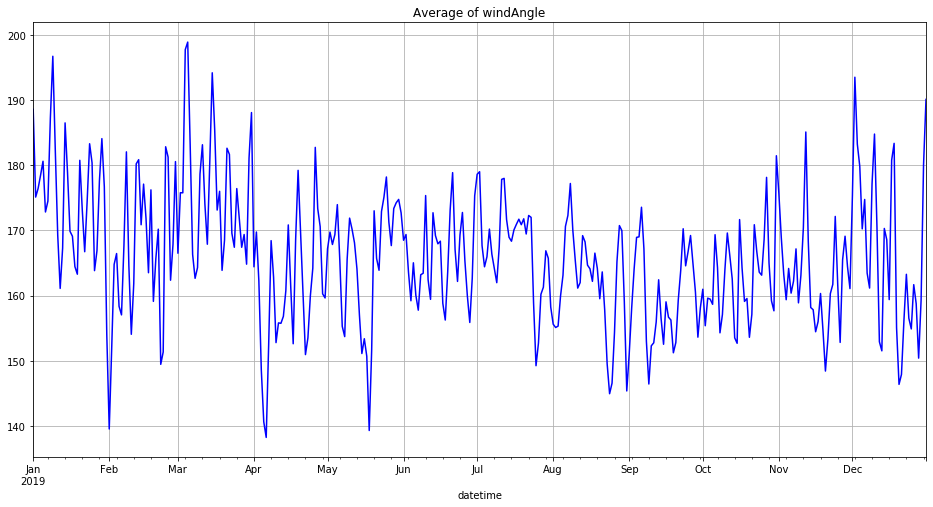

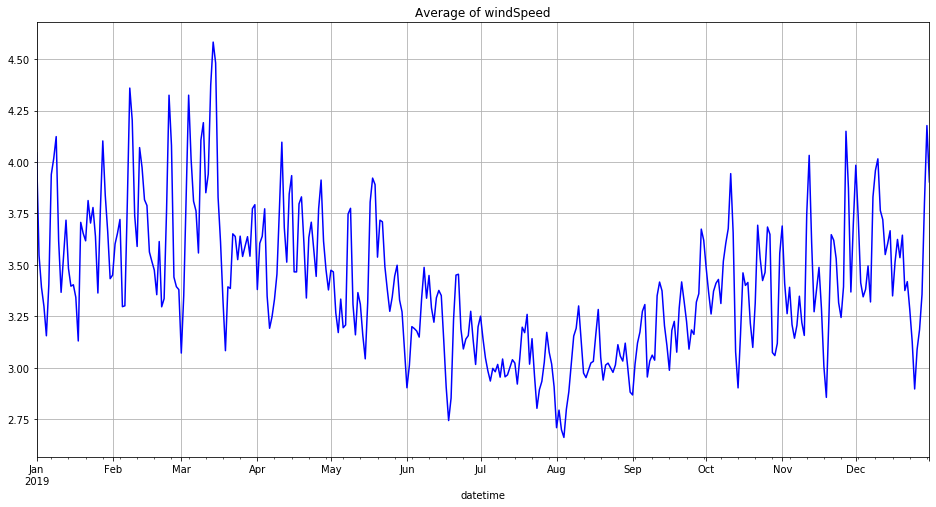

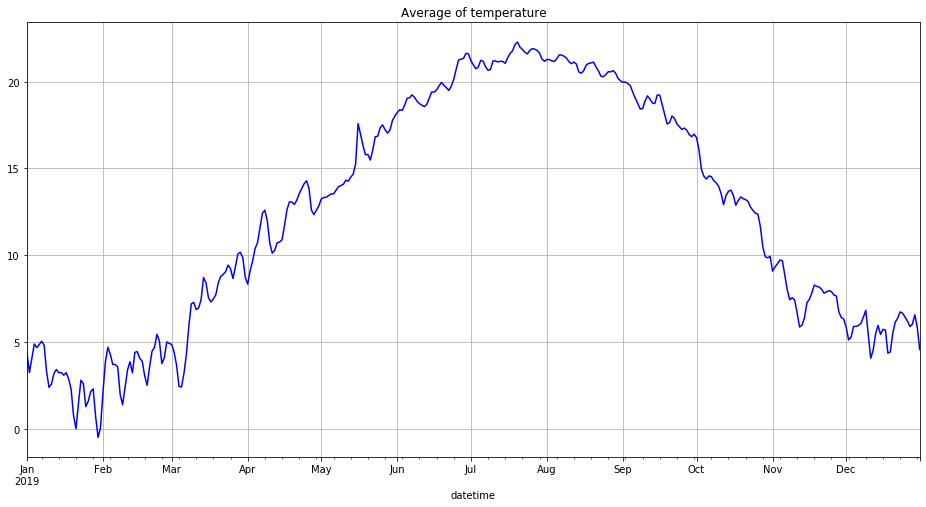

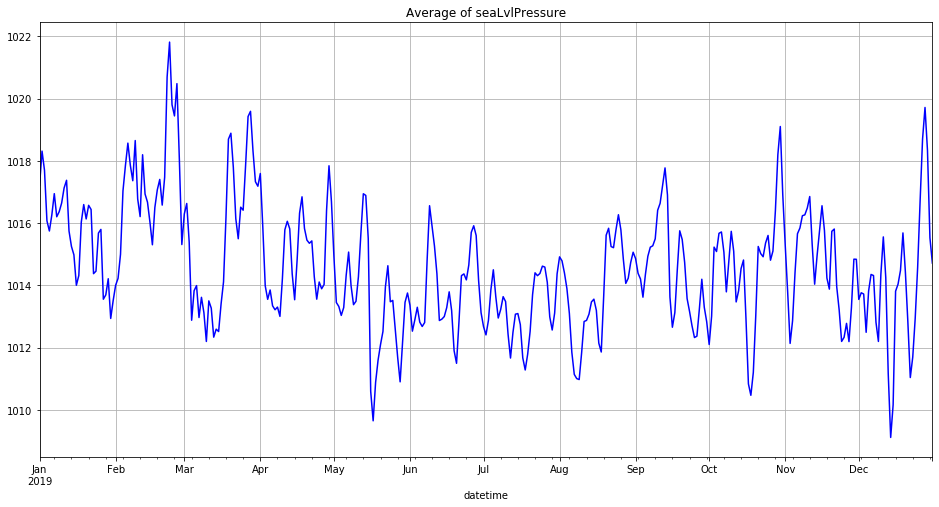

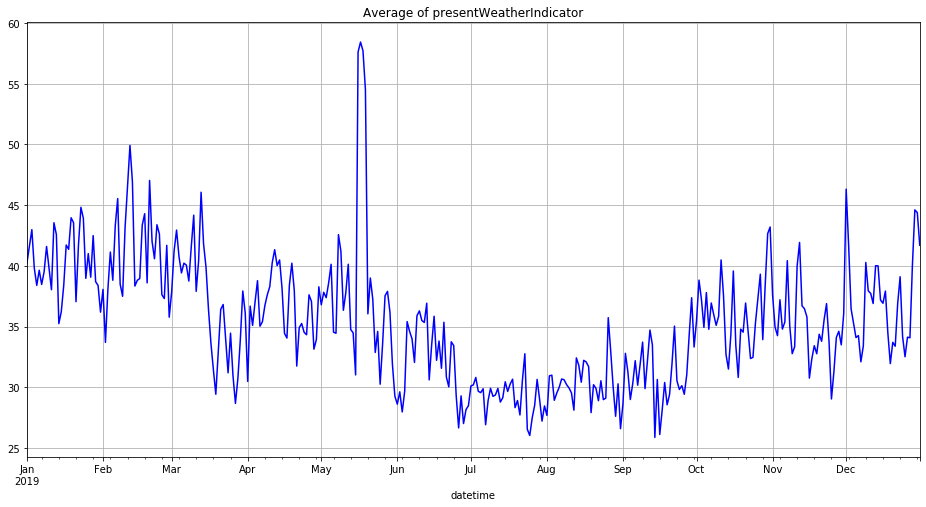

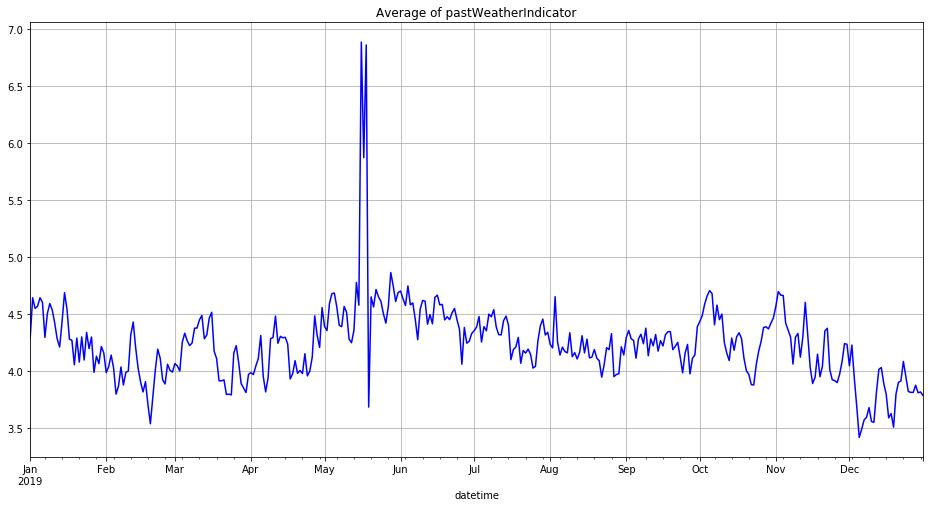

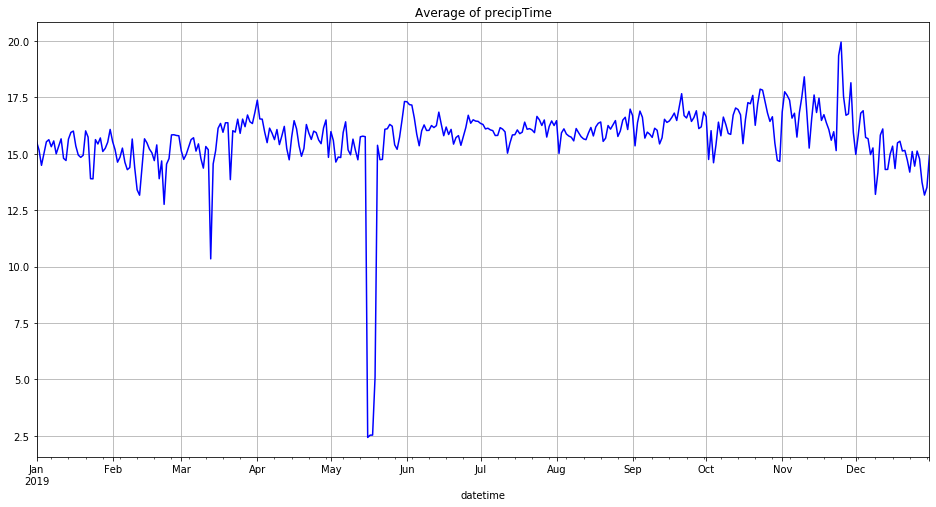

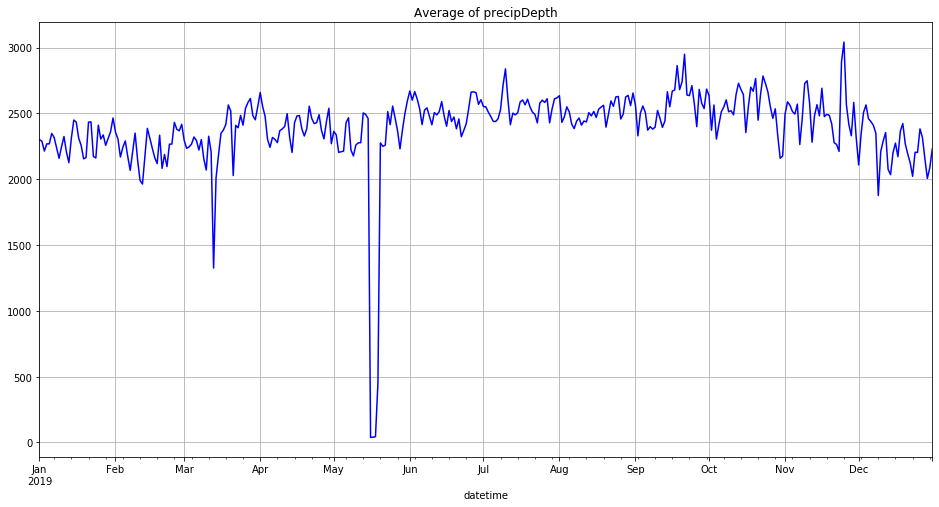

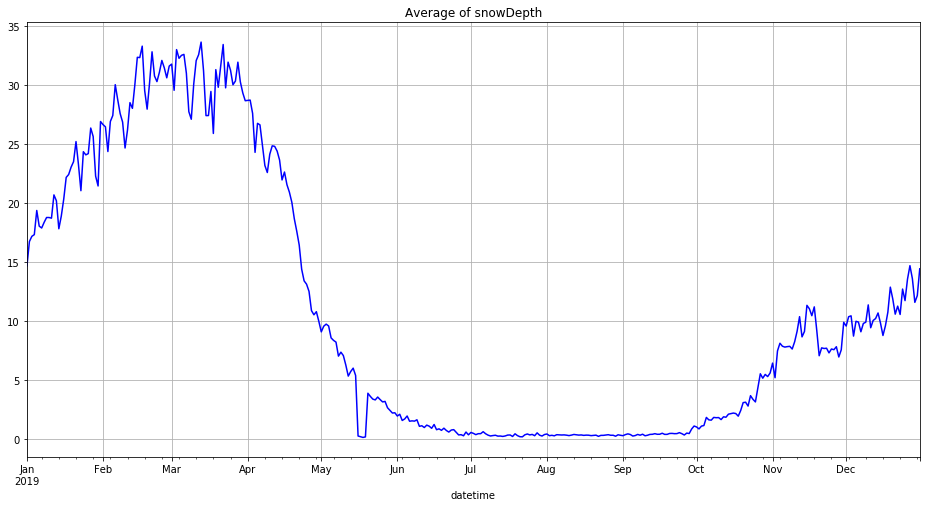

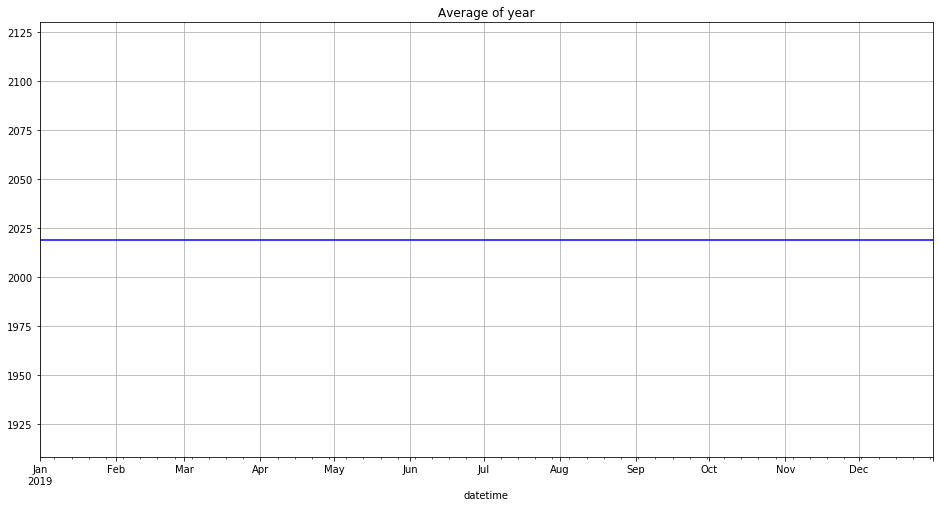

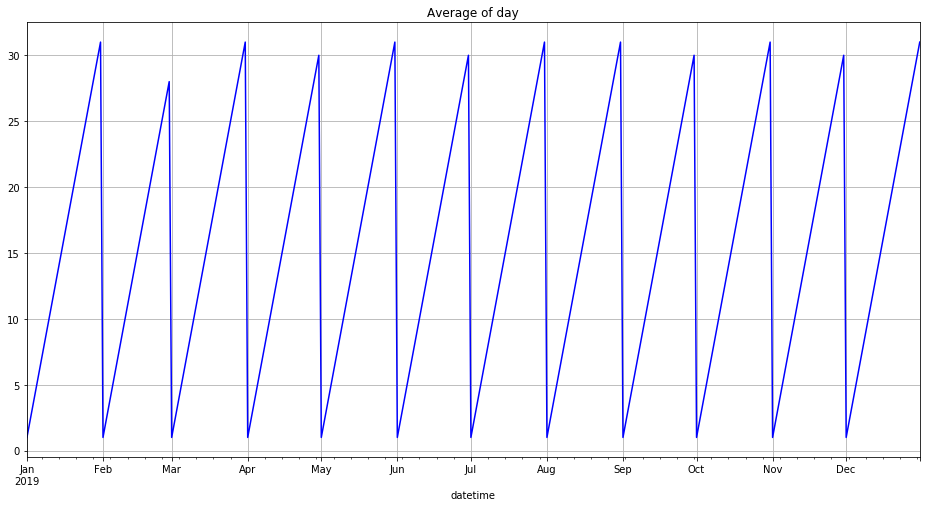

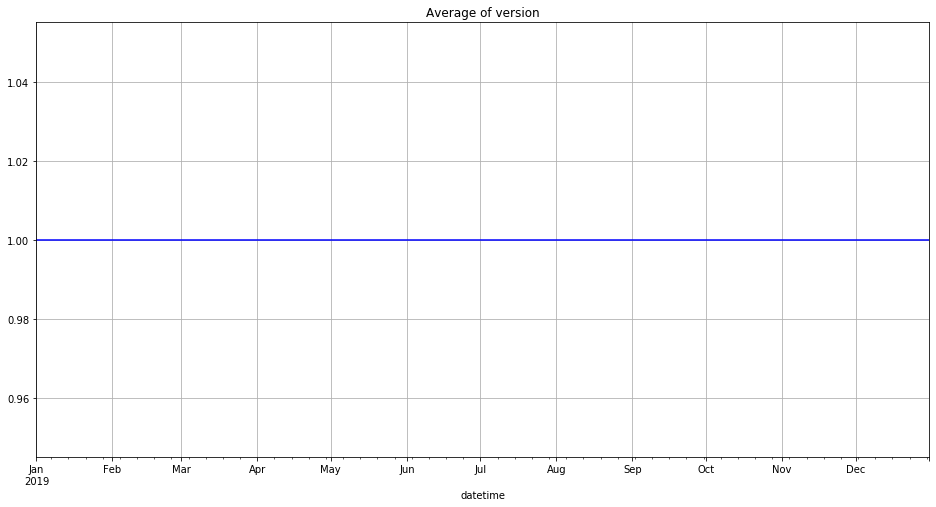

In [24]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(y1, 1, 1), datetime(y2, 12, 31)])
    plt.grid()

In [25]:
c.close()

## Scale up with Dask and Azure ML

In [26]:
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

### Connect to cluster

In [27]:
# port to forward the dask dashboard to on the compute instance
# we do not use 8787 because it is already in use 
dashboard_port = 4242

print("waiting for scheduler node's ip")
while run.get_status() != 'Canceled' and 'scheduler' not in run.get_metrics():
    print('.', end ="")
    time.sleep(5)

if run.get_status() == 'Canceled':
    print('\nRun was canceled')
else:
    print(f'\nSetting up port forwarding...')
    os.system(f'killall socat') # kill all socat processes - cleans up previous port forward setups 
    os.system(f'setsid socat tcp-listen:{dashboard_port},reuseaddr,fork tcp:{run.get_metrics()["dashboard"]} &')
    print(f'Cluster is ready to use.')

c = Client(f'tcp://{run.get_metrics()["scheduler"]}')

print(f'\n\n{c}')

c.restart()

# need to get the dashboard link 
dashboard_url = f'https://{socket.gethostname()}-{dashboard_port}.{ws.get_details()["location"]}.instances.azureml.net/status'
HTML(f'<a href="{dashboard_url}">Dashboard link</a>')

waiting for scheduler node's ip

Setting up port forwarding...
Cluster is ready to use.


<Client: 'tcp://10.2.0.5:8786' processes=50 threads=400, memory=2.95 TB>


### Take all the data

There is an issue with 2019 still working through, ignore it for now.

In [28]:
# adjust amount of data as needed
y1 = 2008
y2 = 2018
# build list of files 
files = [f'{abfs_path}/year={year}/month={m}/*.parquet' for year in range(y1, y2+1) for m in range(1, 12+1)]

In [29]:
df = dask.delayed(dd.read_parquet)(files, engine='pyarrow', storage_options=STORAGE_OPTIONS).compute()
%time df.head()

CPU times: user 210 ms, sys: 16.8 ms, total: 226 ms
Wall time: 8.2 s


,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,724755,93129,2008-01-01 00:53:00,37.702,-113.097,1712.0,350.0,3.6,-8.3,1036.2,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0
1,724755,93129,2008-01-01 01:53:00,37.702,-113.097,1712.0,340.0,4.1,-11.1,1037.3,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0
2,724755,93129,2008-01-01 02:53:00,37.702,-113.097,1712.0,NaN,2.1,-11.7,1039.7,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0
3,724755,93129,2008-01-01 03:53:00,37.702,-113.097,1712.0,70.0,1.5,-11.1,1040.3,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0
4,724755,93129,2008-01-01 04:53:00,37.702,-113.097,1712.0,NaN,1.5,-13.9,1040.4,...,NaN,1.0,0.0,NaN,CEDAR CITY REGIONAL ARPT,US,724755-93129,2008,1,1.0


In [30]:
df = df.set_index(dd.to_datetime(df.datetime).dt.floor('d'), sorted=False)
df = df.persist() # don't run unless dataset fits comfortably in memory 
%time len(df)

CPU times: user 1.46 s, sys: 248 ms, total: 1.71 s
Wall time: 28.3 s


1270243333

In [31]:
%time len(df)

CPU times: user 80.2 ms, sys: 12.7 ms, total: 93 ms
Wall time: 329 ms


1270243333

In [32]:
%time df.describe().compute()

CPU times: user 4.81 s, sys: 138 ms, total: 4.94 s
Wall time: 40.9 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,1.270243e+09,1.270243e+09,1.270243e+09,1.013709e+09,1.053004e+09,1.247780e+09,4.429675e+08,1.133391e+08,4.778603e+07,2.635686e+08,2.635686e+08,6.999535e+06,1.270243e+09,1.270243e+09,1.270243e+09
mean,3.757216e+01,-3.953360e+01,3.982165e+02,1.650804e+02,3.441704e+00,1.197150e+01,1.014653e+03,2.889832e+01,4.276644e+00,8.590938e+00,9.023999e+02,1.885553e+01,2.013246e+03,1.572223e+01,1.000000e+00
std,2.138076e+01,7.862546e+01,5.996861e+02,1.145702e+02,2.869097e+00,1.246356e+01,9.389093e+00,2.905005e+01,2.996370e+00,1.846843e+01,2.849152e+03,3.501295e+01,3.125733e+00,8.811851e+00,0.000000e+00
min,-9.000000e+01,-1.799990e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-8.860000e+01,8.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.008000e+03,1.000000e+00,1.000000e+00
25%,3.405000e+01,-9.532000e+01,5.000000e+01,8.000000e+01,2.000000e+00,8.500000e+00,1.011700e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.012000e+03,8.000000e+00,1.000000e+00
50%,4.161600e+01,-7.116000e+01,2.090000e+02,1.900000e+02,3.600000e+00,1.610000e+01,1.017200e+03,4.500000e+01,6.000000e+00,1.000000e+00,0.000000e+00,1.600000e+01,2.015000e+03,1.600000e+01,1.000000e+00
75%,4.920000e+01,1.769700e+01,5.490000e+02,2.800000e+02,5.700000e+00,2.780000e+01,1.026000e+03,7.100000e+01,8.000000e+00,1.200000e+01,9.999000e+03,6.300000e+01,2.018000e+03,2.400000e+01,1.000000e+00
max,8.733300e+01,9.999990e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.170000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,9.990000e+02,2.018000e+03,3.100000e+01,1.000000e+00


In [33]:
%time bites = df.memory_usage(index=True, deep=True).sum().compute()
print(f'Dataframe is: {round(bites/1e9, 2)}GB')

CPU times: user 466 ms, sys: 74.4 ms, total: 541 ms
Wall time: 15 s
Dataframe is: 626.5GB


In [34]:
%time means = df.groupby(df.index).mean().compute()
means.head()

CPU times: user 336 ms, sys: 17.3 ms, total: 353 ms
Wall time: 11.3 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
2008-01-01,37.851544,-41.404520,351.706004,176.364994,4.031225,0.791217,1021.312605,29.191647,4.171073,5.199203,47.503108,21.776100,2008.0,1.0,1.0
2008-01-02,37.774122,-40.943714,352.504602,180.436673,4.306232,-0.932920,1021.165374,32.632597,4.152460,5.355434,44.483105,22.627133,2008.0,2.0,1.0
2008-01-03,37.781321,-40.130623,352.634351,156.904648,4.358461,-0.866068,1020.247739,32.471547,4.119097,5.402424,47.639126,23.396628,2008.0,3.0,1.0
2008-01-04,37.879647,-40.516726,353.027684,149.716467,4.318913,1.212171,1017.653427,30.277898,3.897811,5.524803,39.277930,22.328746,2008.0,4.0,1.0
2008-01-05,37.956239,-41.565558,358.450412,161.096456,4.328847,3.918379,1013.838332,30.640481,4.154117,5.342658,39.990708,23.943632,2008.0,5.0,1.0


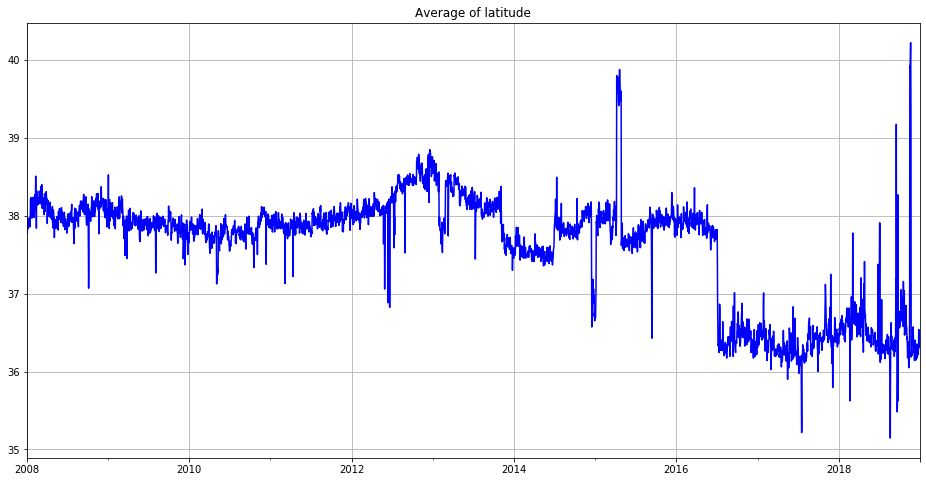

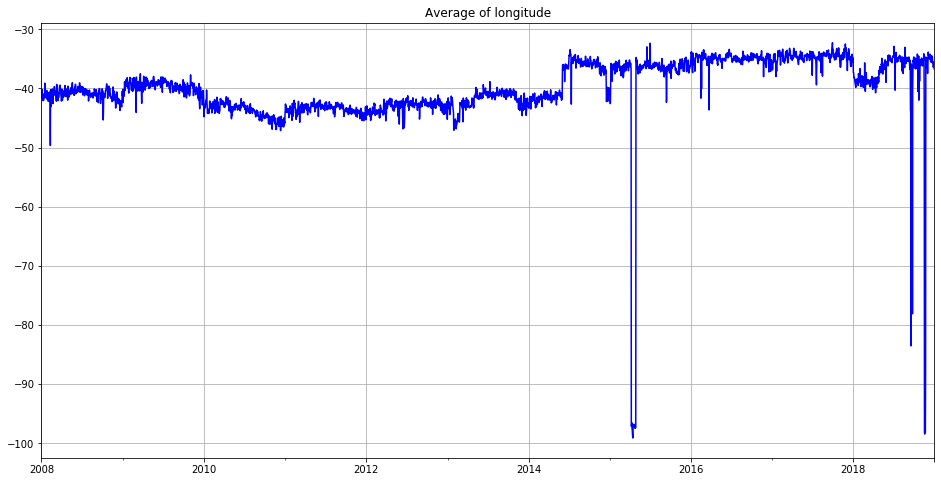

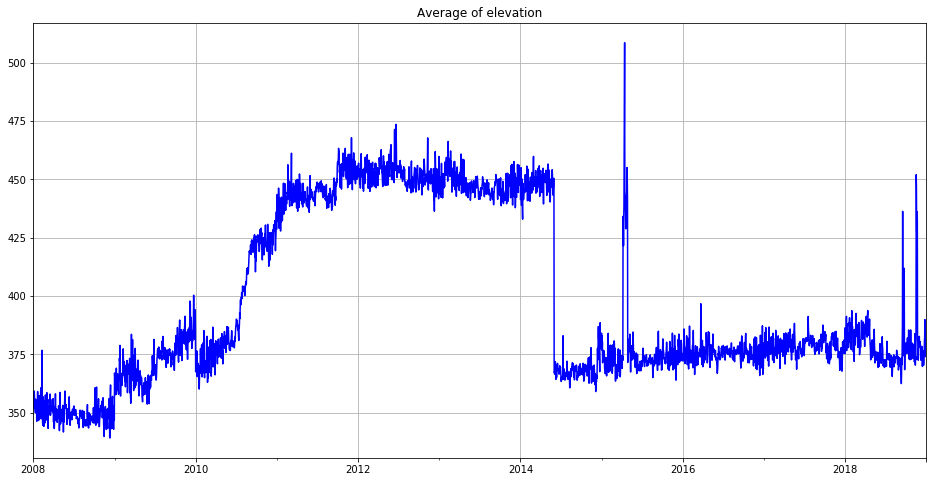

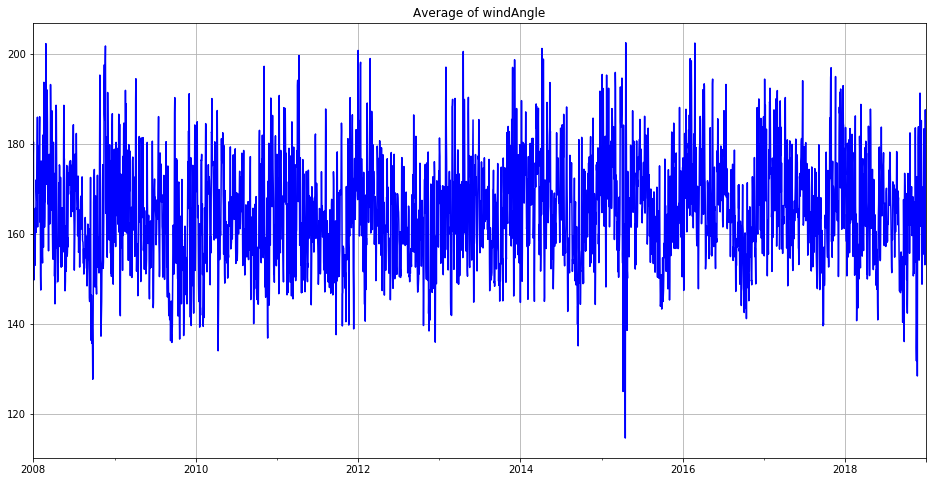

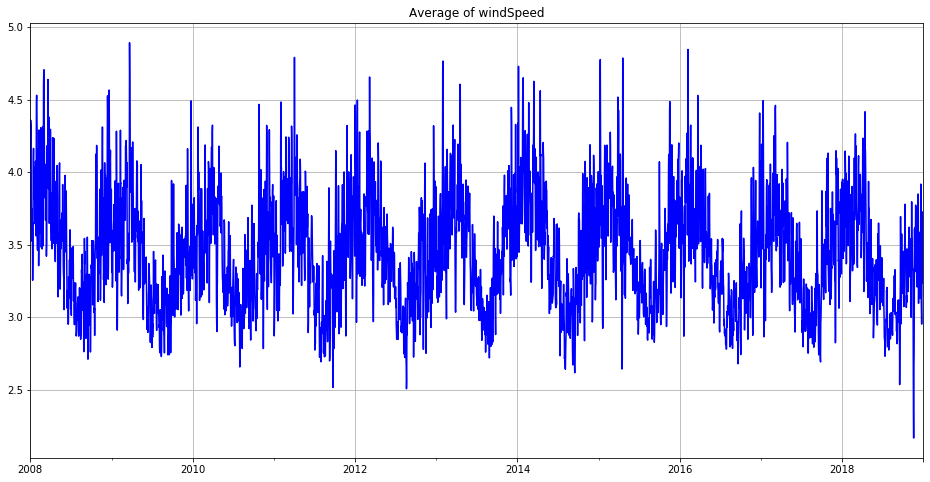

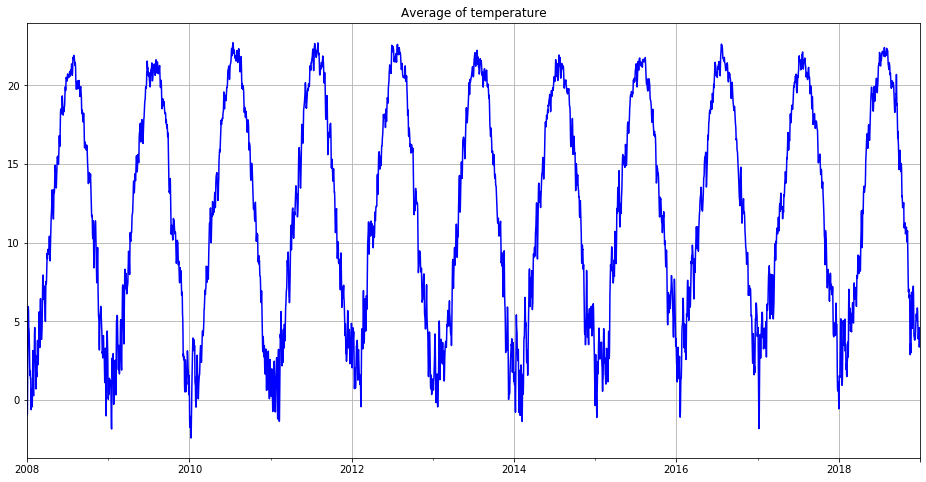

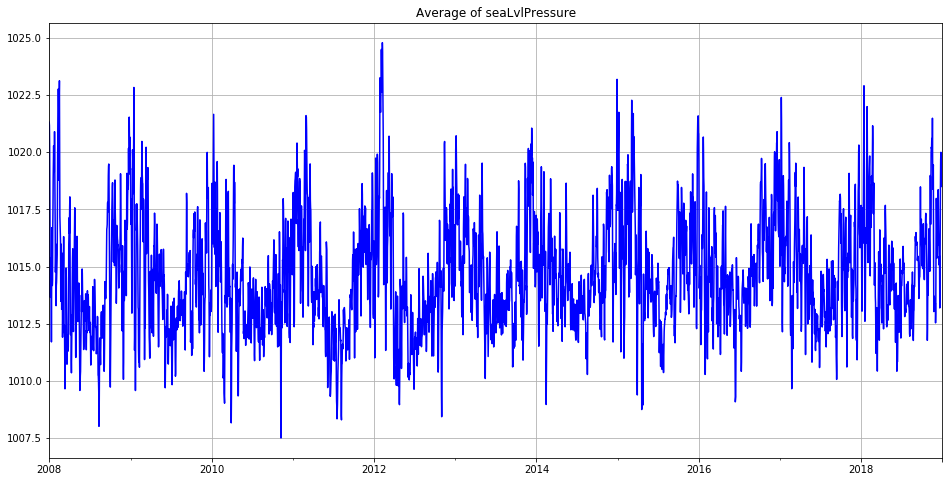

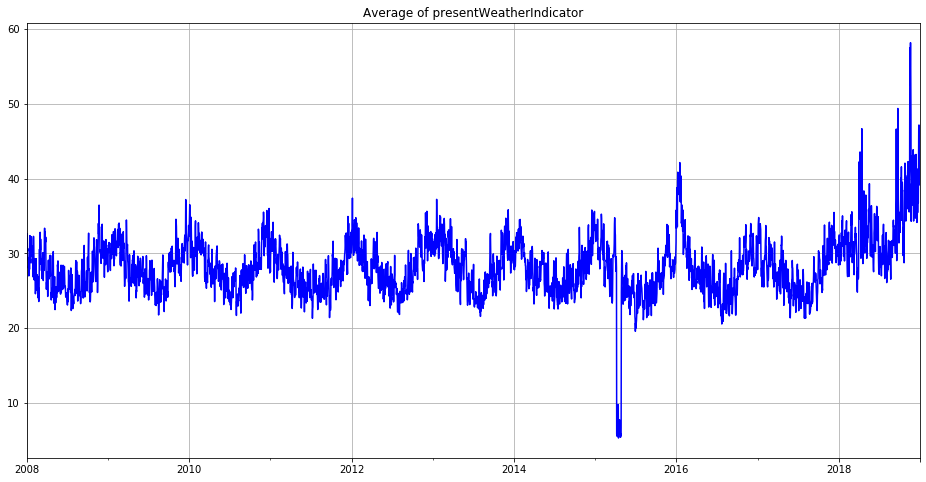

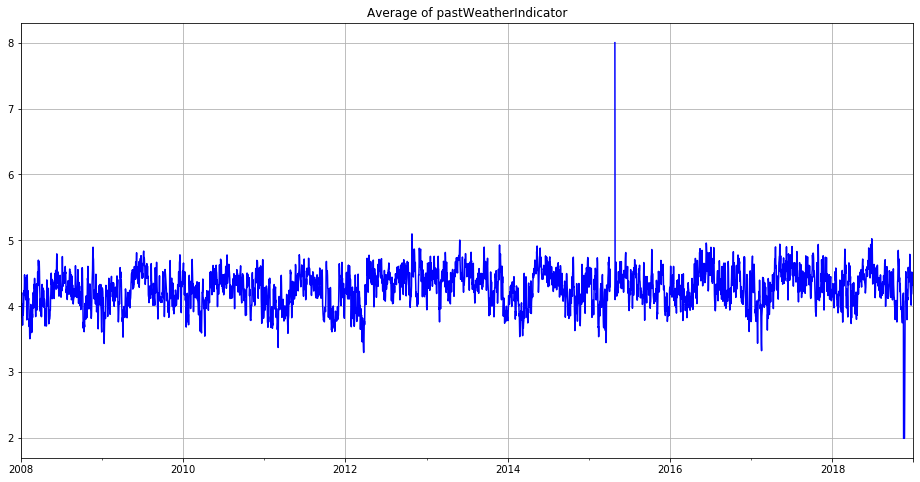

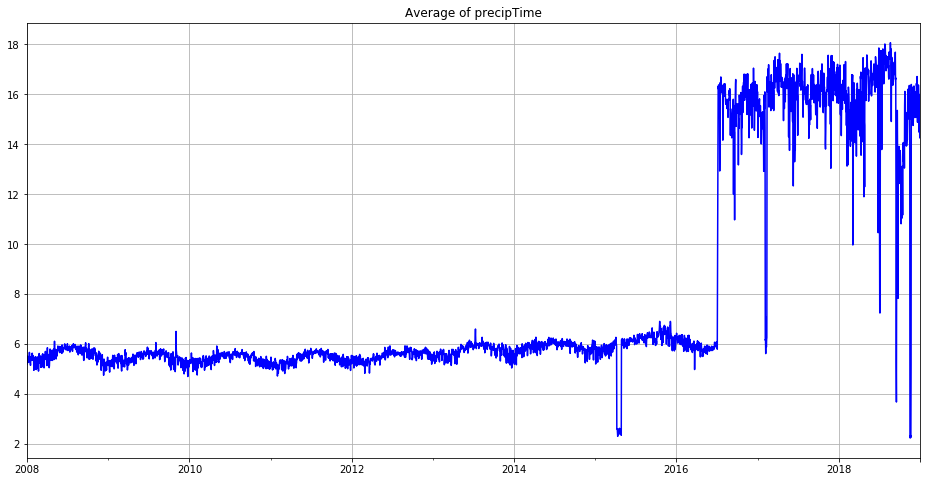

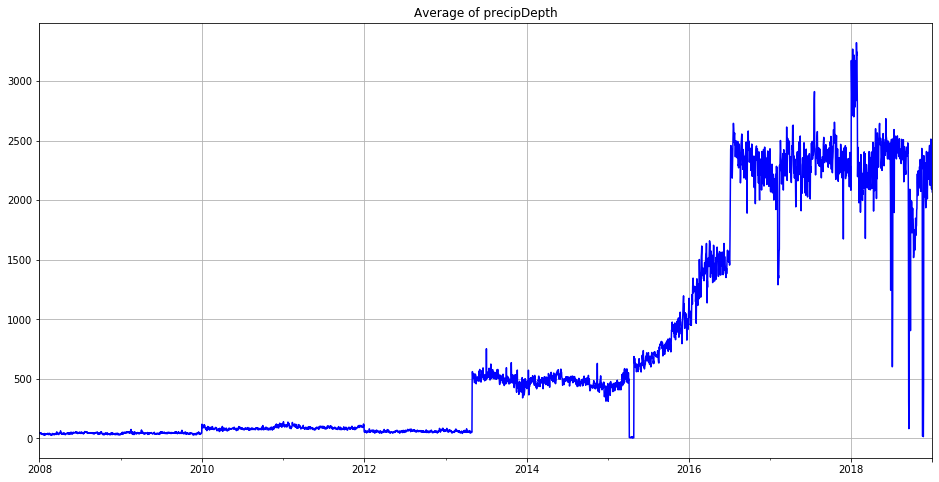

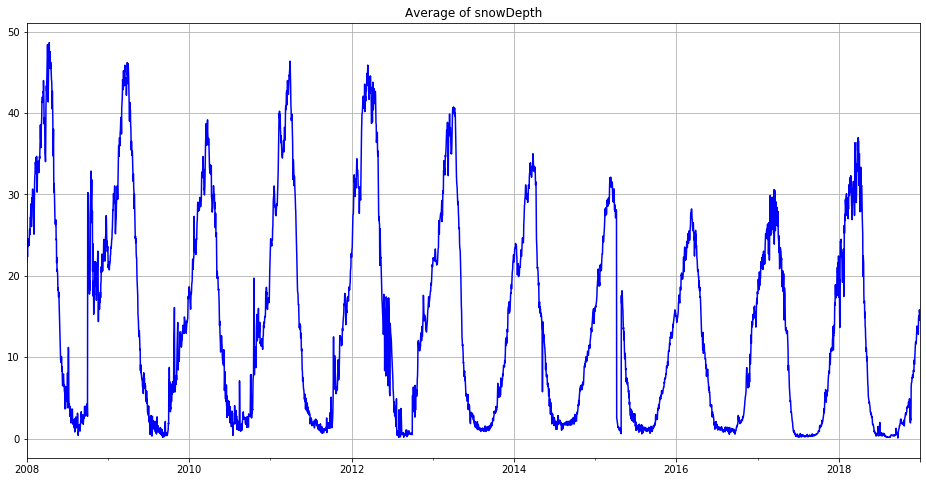

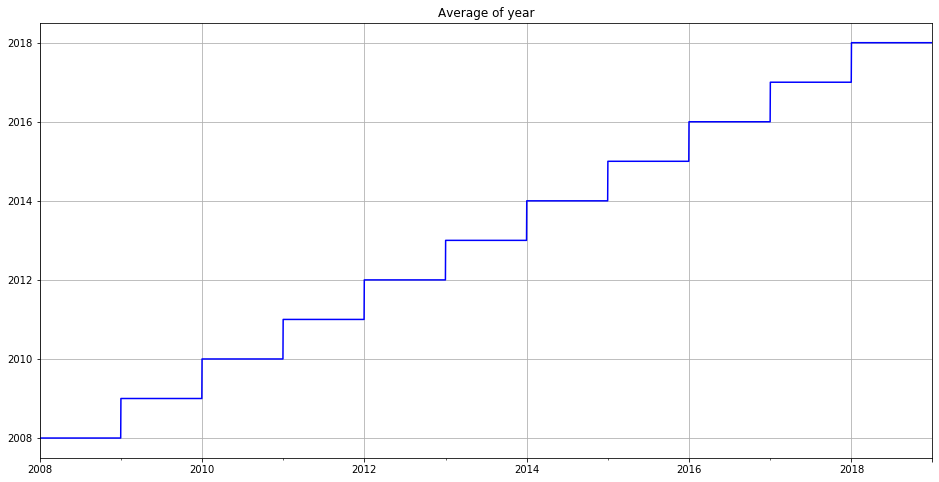

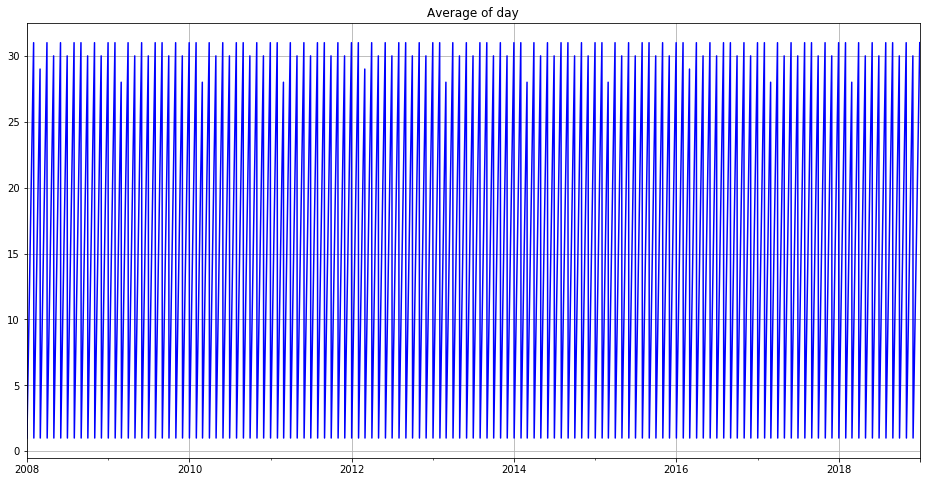

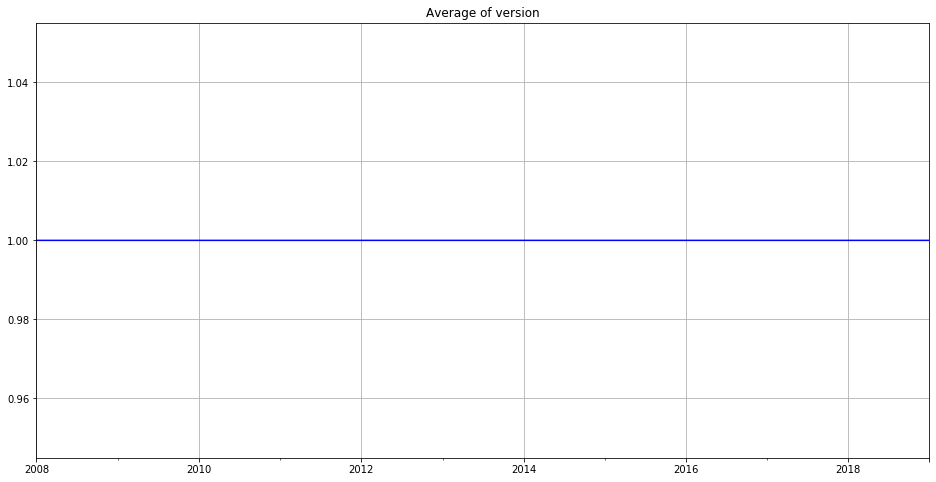

In [35]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(y1, 1, 1), datetime(y2, 12, 31)])
    plt.grid()
    
    # optionally, log the image to the run
    run.log_image(f'mean_{col}', plot=plt)

You can see the images logged to the run in the studio.

In [36]:
run

Experiment,Id,Type,Status,Details Page,Docs Page
dask-interactive,dask-interactive_1578791783_b752dd82,azureml.scriptrun,Running,Link to Azure Machine Learning studio,Link to Documentation


## Prepare data

In [37]:
## insert any Pandas-like Dask data prep code 
df['temperature'] = df['temperature']*(9/5)+32 # 'Merica
df = df.repartition(npartitions=df.npartitions*10)

## Write data

**Important:** you will have not access to write to this account, get your own storage account! 

See the [API documentation for dask.dataframe.to_parquet](https://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.to_parquet) for additional settings like specifying columns for directory-based partitioning. 

In [38]:
%time dask.delayed(df.to_parquet)(f'abfs://outputs/noaa/isd_out.parquet', compression='lz4', storage_options=STORAGE_OPTIONS).compute()

CPU times: user 3.88 s, sys: 289 ms, total: 4.17 s
Wall time: 1min 27s


![Write gif](media/write.gif)

## End the run

Cluster will return to 0 nodes

In [39]:
c.close()
run.cancel()